In [1]:
import os
import xarray as xr
import sys
import itertools
from itertools import zip_longest
from lca_algebraic import initProject
import pandas as pd
import numpy as np
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import matplotlib

### 1. get prepared lcia_ for each module

In [2]:
ds1 = xr.open_dataset('../dlcia_output/V1A_ICEVdGT_dpIRFCRF.nc')
ds2 = xr.open_dataset('../dlcia_output/F2_ICEVdGT_dpIRFCRF.nc')
ds3 = xr.open_dataset('../dlcia_output/V2_ICEVdGT_dpIRFCRF.nc') 

In [3]:
combined_ds = xr.concat([ds1['dplcia'], ds2['dplcia'], ds3['dplcia']], dim='lcia_year')
dscc = combined_ds.to_dataset()

In [4]:
dscc

<xarray.Dataset>
Dimensions:    (ensemble: 1001, SSP: 3, dpLCA_IC: 3, v_year: 3, v_module: 3,
                tech_list: 1, lcia_year: 341)
Coordinates:
  * ensemble   (ensemble) int32 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * dpLCA_IC   (dpLCA_IC) object 'dpIRF' 'dpCRF' 'dpGWP'
  * v_year     (v_year) int32 2030 2040 2050
  * v_module   (v_module) object 'F2_fuel_diesel' 'V1A_V1B_init' 'V2_oper_EF'
  * tech_list  (tech_list) object 'dummy_tech'
  * lcia_year  (lcia_year) int32 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
Data variables:
    dplcia     (SSP, v_year, v_module, tech_list, lcia_year, dpLCA_IC, ensemble) float64 ...

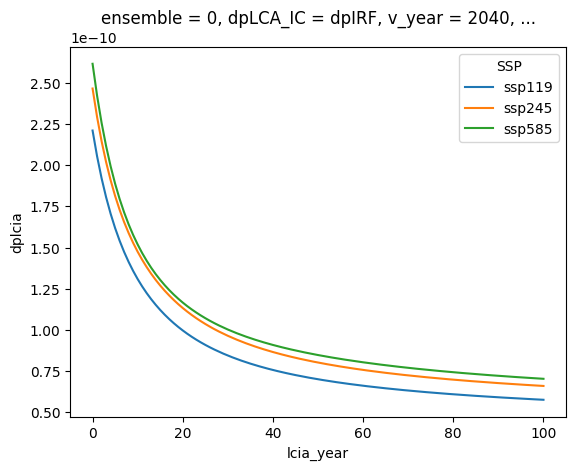

In [5]:
dscc.sel(tech_list = "dummy_tech", dpLCA_IC = 'dpIRF', v_year = 2040, ensemble = 0, v_module = 'V1A_V1B_init')['dplcia'].plot(x = "lcia_year", hue = "SSP");

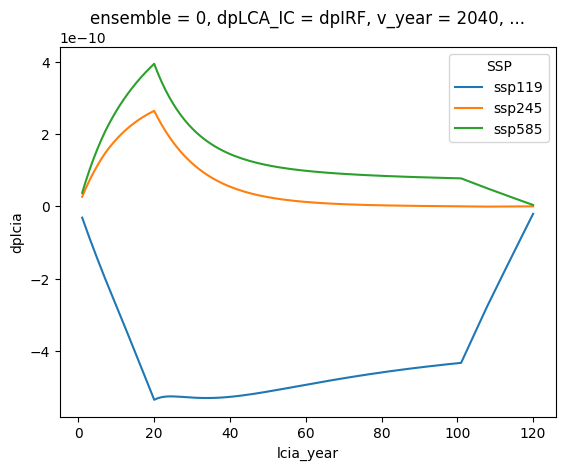

In [6]:
dscc.sel(tech_list = "dummy_tech", dpLCA_IC = 'dpIRF', v_year = 2040, ensemble = 0, v_module = 'F2_fuel_diesel')['dplcia'].plot(x = "lcia_year", hue = "SSP");

## 2. to create a final ds to get all vehicle_module impact (per user-defined mod/tech combination)

In [7]:
""" empty result ds, to combine final vehicle cycle from diff modules, so no v_module in this ds """
ssp, v_year, dpLCA_IC = dscc["SSP"].values, dscc["v_year"].values, dscc["dpLCA_IC"].values
lcia_year = np.array(ds1.indexes['lcia_year'].union(ds2.indexes['lcia_year']).union(ds3.indexes['lcia_year']) )
# Create a new xarray dataset with dimensions
ds = xr.Dataset(coords={'SSP':  ssp, 'v_year': v_year, 'dpLCA_IC': dpLCA_IC, 'lcia_year': lcia_year,   })
empty_data_array = xr.DataArray(np.nan, coords=ds.coords, dims=ds.dims)
ds['dplcia'] = empty_data_array
#ds

### 2.A user-defined tech - only one available tech_comb for ICEV-d, as all 'dummy_tech' prepared for each module

In [8]:
""" need a pre-defined dict for selecting one tech for each module """ 
tech_toget_formod = {'V1A_V1B_init' : 'dummy_tech',
                     'F2_fuel_diesel': 'dummy_tech', 
                     'V2_oper_EF': 'dummy_tech', 
                     }

#allSSPMYlist = [] 
for vy in dscc["v_year"].values: 
    for sp in dscc["SSP"].values:  
        v1mod_toget, v2mod_toget, v3mod_toget = list(tech_toget_formod.keys())[0], list(tech_toget_formod.keys())[1], list(tech_toget_formod.keys())[2]
        sel_ds1 = dscc.sel(v_year = vy, SSP = sp, v_module = v1mod_toget, dpLCA_IC = 'dpIRF',
                           tech_list = tech_toget_formod[v1mod_toget], ensemble = 0  ) 
        sel_ds2 = dscc.sel(v_year = vy, SSP = sp, v_module = v2mod_toget, dpLCA_IC = 'dpIRF',
                           tech_list = tech_toget_formod[v2mod_toget], ensemble = 0  )
        sel_ds3 = dscc.sel(v_year = vy, SSP = sp, v_module = v3mod_toget, dpLCA_IC = 'dpIRF',
                           tech_list = tech_toget_formod[v3mod_toget], ensemble = 0  )
        
        sel_ds11 = sel_ds1.where(sel_ds1['dplcia'].notnull() , drop = True)
        sel_ds22 = sel_ds2.where(sel_ds2['dplcia'].notnull() , drop = True) 
        sel_ds33 = sel_ds3.where(sel_ds3['dplcia'].notnull() , drop = True)
        unionindex = sel_ds11.indexes['lcia_year'].union(sel_ds22.indexes['lcia_year']).union(sel_ds33.indexes['lcia_year'])
    
        """ ICEV-d fill_value = 0 (using nan) as all TRL = 9  """  
        sel_ds111 = sel_ds11.reindex(lcia_year=unionindex, fill_value= 0)
        sel_ds222 = sel_ds22.reindex(lcia_year=unionindex, fill_value=0)
        sel_ds333 = sel_ds33.reindex(lcia_year=unionindex, fill_value=0)
        
        #print(sel_ds111.coords , sel_ds222.coords ,sel_ds333.coords)
        #allds = sel_ds222 + sel_ds111 + sel_ds333
        irfscore = sel_ds111['dplcia'].values + sel_ds222['dplcia'].values + sel_ds333['dplcia'].values
        crfscore = np.cumsum(irfscore)

        alen = ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC': 'dpIRF' }].indexes.dims.get('lcia_year') 
        if len(irfscore) == alen: 
            ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC' : 'dpIRF'}] = irfscore
            ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC' : 'dpCRF'}] = crfscore
             
        else: 
            print(f" dpLCIA score not assigned to ds, diff dim, some tech not available under SSP {sp}, v_year {vy}")


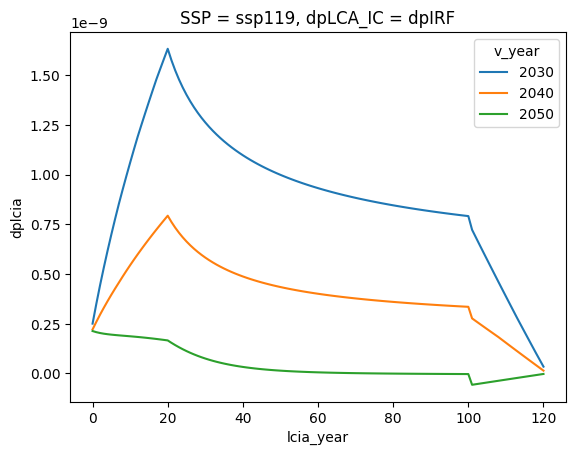

In [9]:
ds.sel(SSP = 'ssp119' , dpLCA_IC =  'dpIRF' )['dplcia'].plot(x = 'lcia_year', hue = 'v_year' );

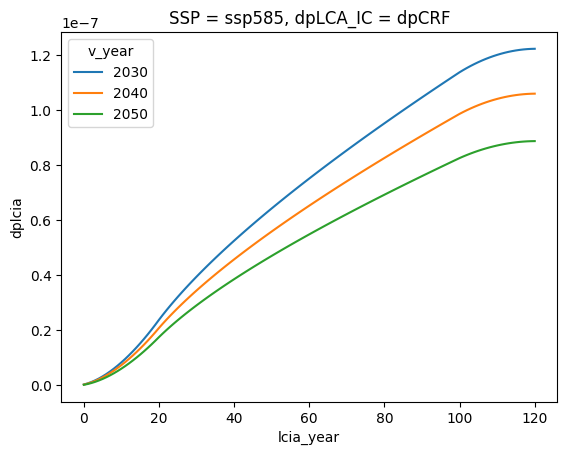

In [10]:
ds.sel(SSP = 'ssp585' , dpLCA_IC =  'dpCRF' )['dplcia'].plot(x = 'lcia_year', hue = 'v_year' );

### 2.B  looping through ALL tech for each module to sum over final vehicle_cycle impacts 

In [11]:
all_tech_toget_formod =  {'V1A_V1B_init' : ['dummy_tech'],
                     'F2_fuel_diesel': ['dummy_tech'], 
                     'V2_oper_EF': ['dummy_tech'], 
                     }
combinations = list(itertools.product(*all_tech_toget_formod.values()))
# Generate dict for each combination
each_tech_toget_formod = [{key: value for key, value in zip(all_tech_toget_formod.keys(), combination)} for combination in combinations]
print(len(each_tech_toget_formod))
each_tech_toget_formod 

1


[{'V1A_V1B_init': 'dummy_tech',
  'F2_fuel_diesel': 'dummy_tech',
  'V2_oper_EF': 'dummy_tech'}]

In [12]:
final_alltech_list = []

for tech_toget_formod in each_tech_toget_formod: 
    """ create empty ds for each mod_tech loop""" 
    ssp, v_year, dpLCA_IC = dscc["SSP"].values, dscc["v_year"].values, dscc["dpLCA_IC"].values
    lcia_year = np.array(ds1.indexes['lcia_year'].union(ds2.indexes['lcia_year']).union(ds3.indexes['lcia_year']) )
    # Create a new xarray dataset with dimensions
    ds = xr.Dataset(coords={'SSP':  ssp, 'v_year': v_year, 'dpLCA_IC': dpLCA_IC, 'lcia_year': lcia_year,   })
    empty_data_array = xr.DataArray(np.nan, coords=ds.coords, dims=ds.dims)
    ds['dplcia'] = empty_data_array
    
    for vy in dscc["v_year"].values: 
        for sp in dscc["SSP"].values:  
            v1mod_toget, v2mod_toget, v3mod_toget = list(tech_toget_formod.keys())[0], list(tech_toget_formod.keys())[1], list(tech_toget_formod.keys())[2]
            sel_ds1 = dscc.sel(v_year = vy, SSP = sp, v_module = v1mod_toget, dpLCA_IC = 'dpIRF',
                               tech_list = tech_toget_formod[v1mod_toget], ensemble = 0  ) 
            sel_ds2 = dscc.sel(v_year = vy, SSP = sp, v_module = v2mod_toget, dpLCA_IC = 'dpIRF',
                               tech_list = tech_toget_formod[v2mod_toget], ensemble = 0  )
            sel_ds3 = dscc.sel(v_year = vy, SSP = sp, v_module = v3mod_toget, dpLCA_IC = 'dpIRF',
                               tech_list = tech_toget_formod[v3mod_toget], ensemble = 0  )
            
            sel_ds11 = sel_ds1.where(sel_ds1['dplcia'].notnull() , drop = True)
            sel_ds22 = sel_ds2.where(sel_ds2['dplcia'].notnull() , drop = True) 
            sel_ds33 = sel_ds3.where(sel_ds3['dplcia'].notnull() , drop = True)
            unionindex = sel_ds11.indexes['lcia_year'].union(sel_ds22.indexes['lcia_year']).union(sel_ds33.indexes['lcia_year'])
        
            """ ICEV-d fill_value = 0 (using nan) as all TRL = 9  """  
            sel_ds111 = sel_ds11.reindex(lcia_year=unionindex, fill_value= 0)
            sel_ds222 = sel_ds22.reindex(lcia_year=unionindex, fill_value=0)
            sel_ds333 = sel_ds33.reindex(lcia_year=unionindex, fill_value=0)
            
            #print(sel_ds111.coords , sel_ds222.coords ,sel_ds333.coords)
            #allds = sel_ds222 + sel_ds111 + sel_ds333
            irfscore = sel_ds111['dplcia'].values + sel_ds222['dplcia'].values + sel_ds333['dplcia'].values
            crfscore = np.cumsum(irfscore)
    
            alen = ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC': 'dpIRF' }].indexes.dims.get('lcia_year') 
            if len(irfscore) == alen: 
                ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC' : 'dpIRF'}] = irfscore
                ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC' : 'dpCRF'}] = crfscore
                 
            else: 
                print(f" dpLCIA score not assigned to ds, diff dim, some tech not available under SSP {sp}, v_year {vy}")

    final_alltech_list.append(ds)

In [13]:
""" for ICEV-d, only one final module/tech_combination """ 
print(len(final_alltech_list))
final_alltech_list[0]

1


<xarray.Dataset>
Dimensions:    (SSP: 3, v_year: 3, dpLCA_IC: 3, lcia_year: 121)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * v_year     (v_year) int32 2030 2040 2050
  * dpLCA_IC   (dpLCA_IC) object 'dpIRF' 'dpCRF' 'dpGWP'
  * lcia_year  (lcia_year) int32 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
Data variables:
    dplcia     (SSP, v_year, dpLCA_IC, lcia_year) float64 2.503e-10 ... nan

### legend by SSP - select a v_year then plot all it's possible tech_combination to build the vehicle 
- <font color = 'red'> it's the same one PLOT you'll get from 2.A, as only one final possible module/tech_comb </font>


{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


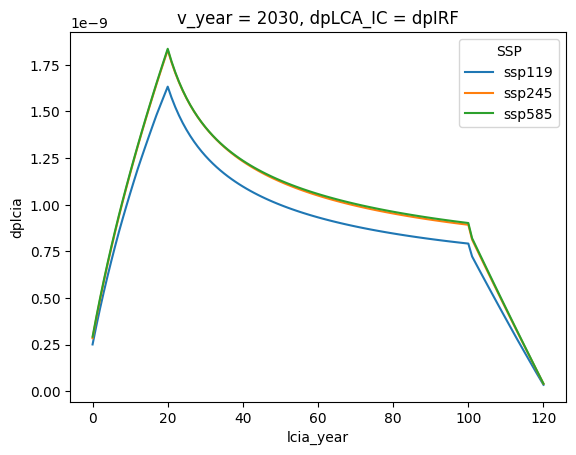

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


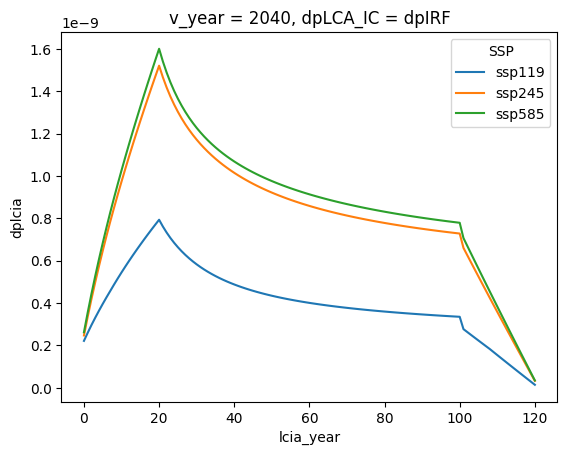

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


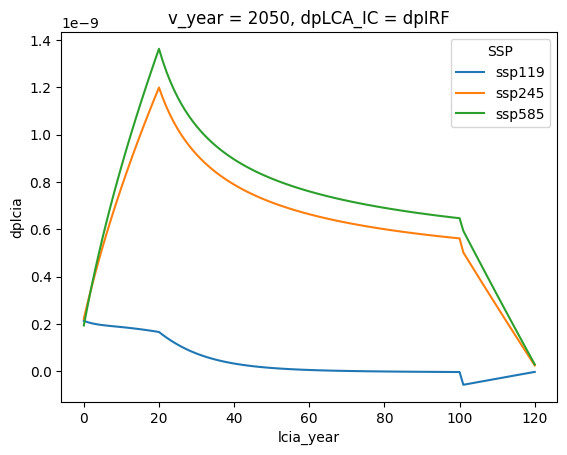

In [14]:
for v_y_toplot in [2030, 2040, 2050]:
    for i in range(len(final_alltech_list)): 
        print(each_tech_toget_formod[i])
        ds_toget = final_alltech_list[i].sel(v_year = v_y_toplot ,  dpLCA_IC = 'dpIRF') 
        ds_toplot = ds_toget.where(ds_toget['dplcia'].notnull() , drop = True)
        if len(ds_toplot['dplcia']) == 0: 
            print(f"the module/tech_combination is not available under any SSP[x] for {each_tech_toget_formod[i]}")
        else:
            ds_toplot['dplcia'].plot(x = 'lcia_year', hue = 'SSP'  );
            plt.show()

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


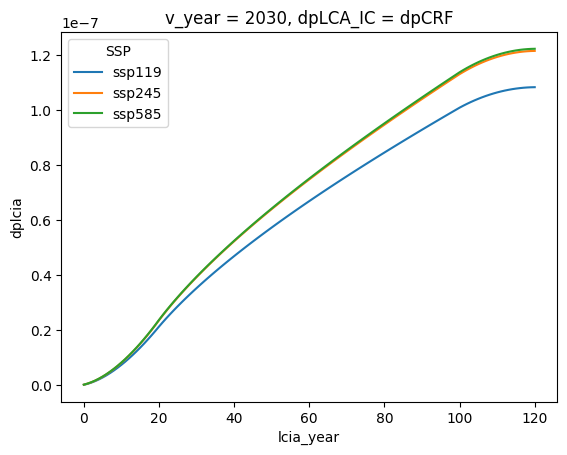

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


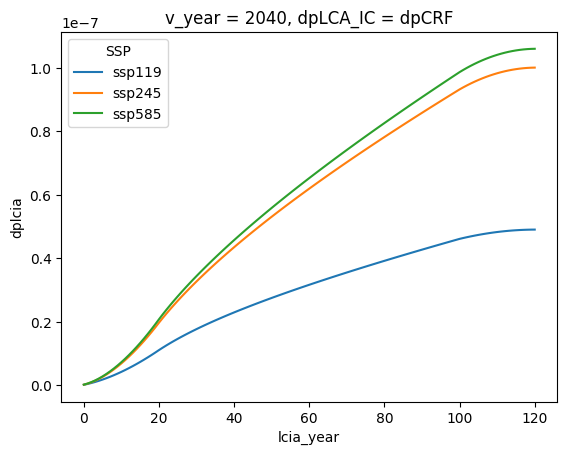

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


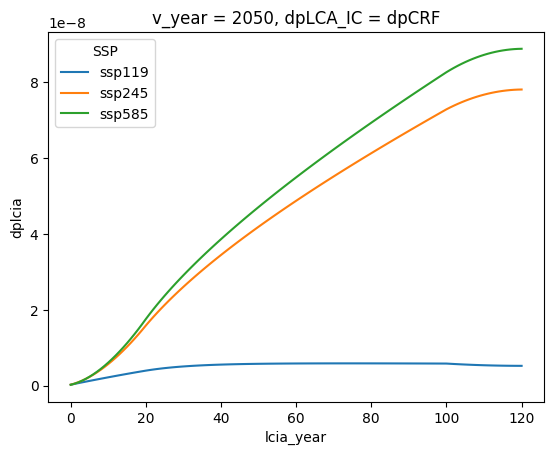

In [15]:
for v_y_toplot in [2030, 2040, 2050]:
    for i in range(len(final_alltech_list)): 
        print(each_tech_toget_formod[i])
        ds_toget = final_alltech_list[i].sel(v_year = v_y_toplot ,  dpLCA_IC = 'dpCRF') 
        ds_toplot = ds_toget.where(ds_toget['dplcia'].notnull() , drop = True)
        if len(ds_toplot['dplcia']) == 0: 
            print(f"the module/tech_combination is not available under any SSP[x] for {each_tech_toget_formod[i]}")
        else:
            ds_toplot['dplcia'].plot(x = 'lcia_year', hue = 'SSP'  );
            plt.show()

### legend by v_year - select one SSP then plot all it's possible tech_combination for different v_year

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


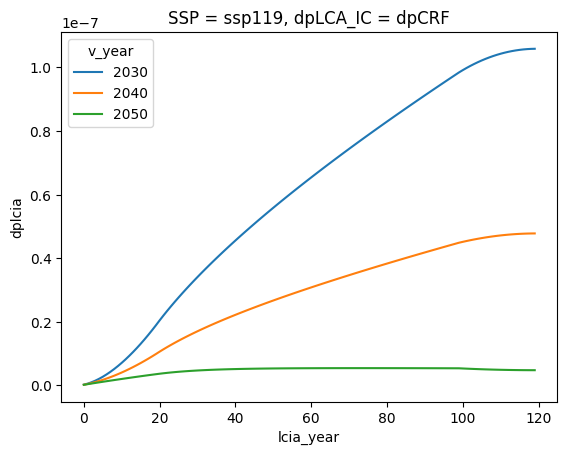

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


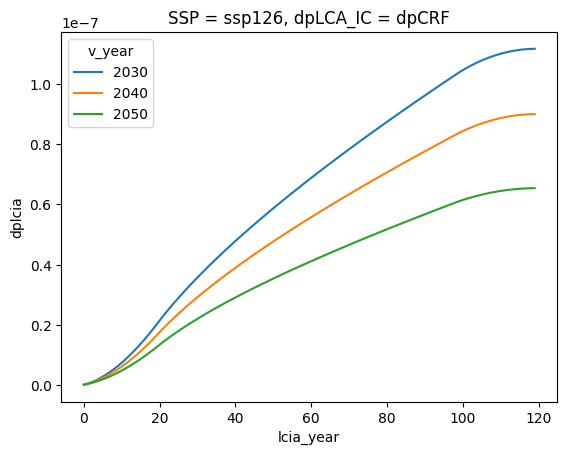

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


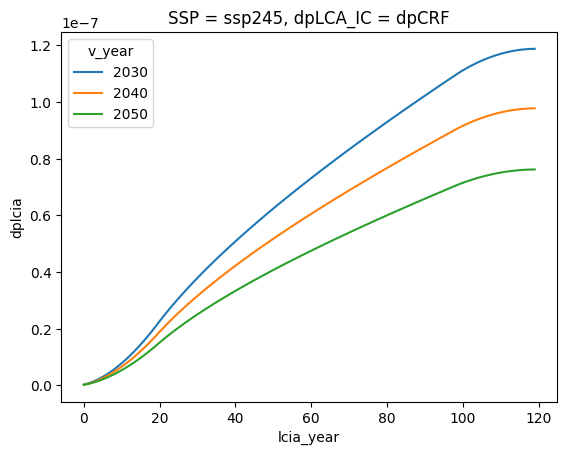

{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


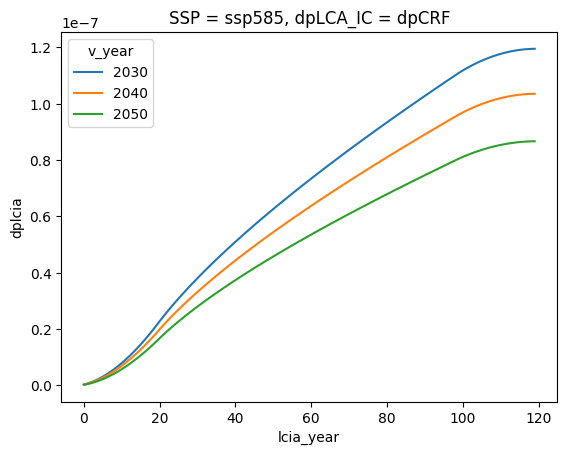

In [16]:
for sp in ['ssp119', 'ssp126', 'ssp245', 'ssp585' ]: 
    for i in range(len(final_alltech_list)): 
        print(each_tech_toget_formod[i])
        ds_toget = final_alltech_list[i].sel(SSP = sp ,  dpLCA_IC = 'dpCRF') 
        ds_toplot = ds_toget.where(ds_toget['dplcia'].notnull() , drop = True)
        if len(ds_toplot['dplcia']) == 0: 
            print(f"the module/tech_combination is not available under any SSP[x] for {each_tech_toget_formod[i]}")
        else:
            ds_toplot['dplcia'].plot(x = 'lcia_year', hue = 'v_year'  );
            plt.show()

### export all ds for each tech combination  

In [16]:
combined_ds_techdict = list(zip(each_tech_toget_formod, final_alltech_list))

In [17]:
""" for each combined_ds_techdict[i], the 1st element is the dict for tech_comb, the 2nd element is the ds""" 
print(len(combined_ds_techdict))
print(combined_ds_techdict[0][0])
combined_ds_techdict[0][1]

1
{'V1A_V1B_init': 'dummy_tech', 'F2_fuel_diesel': 'dummy_tech', 'V2_oper_EF': 'dummy_tech'}


<xarray.Dataset>
Dimensions:    (SSP: 3, v_year: 3, dpLCA_IC: 3, lcia_year: 121)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * v_year     (v_year) int32 2030 2040 2050
  * dpLCA_IC   (dpLCA_IC) object 'dpIRF' 'dpCRF' 'dpGWP'
  * lcia_year  (lcia_year) int32 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
Data variables:
    dplcia     (SSP, v_year, dpLCA_IC, lcia_year) float64 2.503e-10 ... nan

In [18]:
import pickle
with open('../dlcia_output/final_allV_mod/ICEVd_comb_final_ds_1dict.pkl', 'wb') as f:
    pickle.dump(combined_ds_techdict, f)